In [10]:
from Bio.Seq import Seq
from Bio import SeqIO
from collections import Counter
from Bio.PDB import PDBParser
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score,classification_report,confusion_matrix
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import json
import time
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import nglview as nv

In [11]:
for record in SeqIO.parse('pink1.fasta','fasta'):
    pink = record
    pink_dna = record.seq
print(pink)

ID: NG_008164.1
Name: NG_008164.1
Description: NG_008164.1 Homo sapiens PTEN induced kinase 1 (PINK1), RefSeqGene on chromosome 1; nuclear gene for mitochondrial product
Number of features: 0
Seq('CACAGGCCATTTGTCACTCATATTTGGCTCAGAATAAACCTCTTCAAATATTTT...TTA', SingleLetterAlphabet())


In [12]:
mrna_pink = pink_dna.transcribe()
mrna_pink

Seq('CACAGGCCAUUUGUCACUCAUAUUUGGCUCAGAAUAAACCUCUUCAAAUAUUUU...UUA', RNAAlphabet())

In [13]:
protein_pink = mrna_pink.translate()
len(protein_pink), protein_pink

C:\Users\kunjk\kunj\lib\site-packages\Bio\Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


(8352,
 Seq('HRPFVTHIWLRINLFKYFTEFDSFH*QKIQGCLRNGM*TKKK****CGRSIKSP...D*L', HasStopCodon(ExtendedIUPACProtein(), '*')))

In [14]:
#finding all amino acids sequence before stop codon
pink_aa= protein_pink.split('*')
pink_aa

[Seq('HRPFVTHIWLRINLFKYFTEFDSFH', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('QKIQGCLRNGM', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('TKKK', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('CGRSIKSPTPFSSNSVAGHIKAYLVKS', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('CSVNE', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('DFHTEY', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('ICNINRYSSENHILSCTP', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('IYTHTMYS', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('KFFKNQPNMARHGGSCL', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('SQHFGRLRWADHPRLGVQDQPDQHGETPSLLKIQKLARCGGTCL', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('SPLLRRLRQKNYLNPGGGGCGEPRSRHCTPAWATRAKLHLKKNKNKKNQPNKNYLSLY', HasStopCodon(ExtendedIUPACProtein(), '*')),
 Seq('SVFMLLIKTYLRLVRKRGLIGLTVPHGWG

In [15]:
pink_aa_string = [str(i) for i in pink_aa]
pink_aa_string

['HRPFVTHIWLRINLFKYFTEFDSFH',
 'QKIQGCLRNGM',
 'TKKK',
 '',
 '',
 '',
 'CGRSIKSPTPFSSNSVAGHIKAYLVKS',
 'CSVNE',
 'DFHTEY',
 'ICNINRYSSENHILSCTP',
 'IYTHTMYS',
 'KFFKNQPNMARHGGSCL',
 'SQHFGRLRWADHPRLGVQDQPDQHGETPSLLKIQKLARCGGTCL',
 'SPLLRRLRQKNYLNPGGGGCGEPRSRHCTPAWATRAKLHLKKNKNKKNQPNKNYLSLY',
 'SVFMLLIKTYLRLVRKRGLIGLTVPHGWGGLRIMAGGKRHFLHGGGKRK',
 'GRYKSGNP',
 '',
 'NYQIS',
 'DLFTTTRILWGKPPP',
 'LKLSPTGSLPQHVGIMGVQFKMRFGWGHRAKTYQSYIQFHLFGIPLKR',
 'EARGSGSFL',
 'PQRCGGSIT',
 'CQEFETSLGK',
 'QDPISTKYFLN',
 'LDIVV',
 'AVVPTIWEAEGGRLLEPRNSRLQ',
 'PMIIPLHSSLGDRTRPCLINK',
 'INK',
 'IKRWEMLWENLKMIP',
 'DLRPMAPP',
 'KEFFLLRRIDRDEWSQDHCPWEMHACAPGTVRLYL',
 'PER',
 'ECRTPEILAGNLSLPKSTYLSIPYRCLPKNQASCCA',
 'FRPVRLQIFLQMEK',
 'VSPAYNGRLINISLEISFPADGLRIAGPVSSFAAQGNKCKGLRQTYSLTQDNQYNVL',
 'AVWSS',
 'ASY',
 'KVMFLGD',
 'RKSL',
 'LKH',
 'ISQRTSFSFSINIKERSYNGNVDQKKKKPNSVNYLKRFILSQYE',
 'SWLRVQSQEVLRKDAQGGWVTAWFYTF',
 'GDRSDRQKYKSIHGRHIHWFSLERWNILKQWMLIGSTWSQRFSDWQLVERVKLCLKN',
 'TQ',
 'KETLELR',
 'GGLQKPR

In [16]:
amino_pink = pd.DataFrame({'amino_acids':pink_aa_string})
amino_pink

,amino_acids
0,HRPFVTHIWLRINLFKYFTEFDSFH
1,QKIQGCLRNGM
2,TKKK
3,
4,
...,...
344,PISLIKSNFLGRVNQ
345,SPSHCCPP
346,QIHTPLQKKCSY
347,DISFHARLCISPGMLRCRD


In [17]:
amino_pink['count'] = amino_pink['amino_acids'].str.len()
amino_pink.head()

,amino_acids,count
0,HRPFVTHIWLRINLFKYFTEFDSFH,25
1,QKIQGCLRNGM,11
2,TKKK,4
3,,0
4,,0


In [25]:
amino_pink.to_csv('amino_pink.csv',sep=',')

In [19]:
#largest sequence before stop codon
amino_pink.nlargest(10,'count')


,amino_acids,count
85,RRQYQHSAPTRRVGELPRGPAPPTSACACAEAPPQVCCDRRGTPVV...,195
200,ERGSTVHMLFFPRISCSCFPLACSPLAPHGPSEVSWLPLHCRLADF...,165
138,SGRRGPRLAAPLSASPVSLFLGLPRLPGSRCILFSSQAIFTQKSKP...,161
121,LQHCTPSWATSRSVLVASSKNLYYKNIYIMCIYMYMCIYVVYTIIC...,153
237,DSISKKKKKTYWESSMCGSQRPSPLSASYPCTLRQYLCVNTPSPRL...,121
55,DRVSLCHPGWSGEWSGTITAHCSPNPLDSSNPPASDSQVAGTSGTC...,112
224,RPGPWPDAVPRYEEVSDSSAAGPGADTSPKGSWFLPSMCTLIRGFW...,111
155,FLPDLLDTGFICPESPSQYNEDNKVLSPLFGFCLFVVGDGGRLFCD...,106
276,AISPCQLCLAGGFSRDIGGPLRGKEGRRNGHFACSFPDGCPWLVIA...,106
266,LRDPPASASQSAGIIIFSGDGVSLLARLVSNSWPQVIHPPQPPKCW...,102


In [20]:
#finding the most common amino acids in with the frequency available in the sequence
Counter(protein_pink).most_common(10)

[('L', 904),
 ('S', 817),
 ('G', 652),
 ('P', 591),
 ('R', 534),
 ('A', 531),
 ('V', 396),
 ('T', 383),
 ('K', 352),
 ('*', 348)]

In [21]:
amino_pink.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   amino_acids  349 non-null    object
 1   count        349 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.6+ KB


In [22]:
amino_pink.isnull().sum()

amino_acids    0
count          0
dtype: int64

C:\Users\kunjk\kunj\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


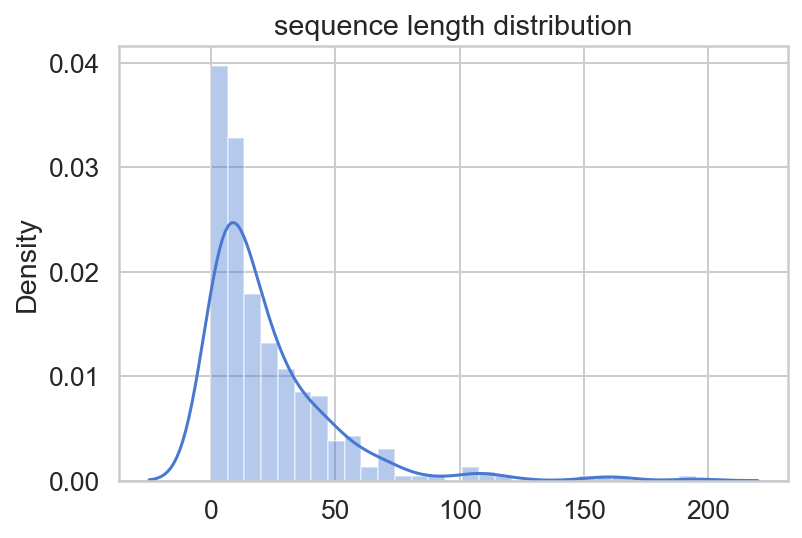

In [23]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
ax = sns.distplot(amino_pink['count'].values)
plt.title(f'sequence length distribution')
plt.grid(True) 
#mostly data covered with in the range of 40